In [1]:
import torch
import math

import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from scipy.stats import norm, gaussian_kde
from tqdm import tqdm
from vae_base import *

# Import utils scripts to train, visualize VAEs
import utils

### 1. Unit Test 1

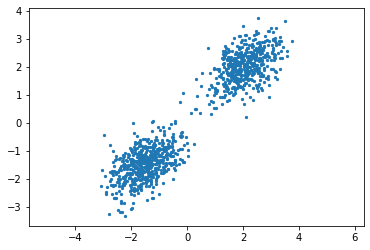

In [2]:
# Prepare x_train
c_means = [[-1.5, -1.5], [2.0, 2.0]]
c_var = 0.30**2
x_var = 1e-2

indices = np.random.randint(2, size=1000)
train_samples = [np.random.multivariate_normal(c_means[i], c_var * np.eye(2) + 0.2 * np.ones((2, 2))) + np.random.multivariate_normal(np.zeros(2), x_var**0.5 * np.eye(2)) for i in indices]

indices = np.random.randint(2, size=500)
val_samples = [np.random.multivariate_normal(c_means[i], c_var * np.eye(2) + 0.2 * np.ones((2, 2))) + np.random.multivariate_normal(np.zeros(2), x_var**0.5 * np.eye(2)) for i in indices]

x_train = np.array(train_samples)
x_val = np.array(val_samples)
plt.scatter(x_train[:, 0], x_train[:, 1], s=5.0)
plt.axis('equal')
plt.show()

  0%|          | 16/5000 [00:06<59:42,  1.39it/s] 

At iteration 18 aggresive_flag is set to False


100%|██████████| 5000/5000 [00:59<00:00, 84.41it/s]


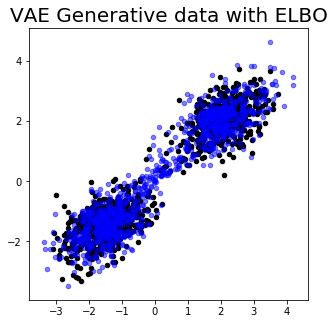

In [3]:
# Train with ELBO, and visualize 
# Most arguments of the following functions have reasonable default settings, i list them all here for a pedagogical reason
device = 'cpu'
elbo_vae_instance = utils.train_ELBO_LIN_VAE_batched(x_train,
                                                 x_val,
                                                 x_var=x_var,
                                                 z_dim=2,
                                                 width=50,
                                                 hidden_layers=1,
                                                 learning_rate=0.01,
                                                 S=10,
                                                 n_epochs=5000,
                                                 report_iter=50,
                                                 batch_size=256,
                                                 device=device)
utils.visualize_VAE(elbo_vae_instance, 
                    x_train, 
                    "ELBO", 
                    x_var=x_var,
                    number_samples=1000,
                    figsize=(5,5))

  0%|          | 13/5000 [00:08<1:23:05,  1.00it/s]

At iteration 18 aggresive_flag is set to False


100%|██████████| 5000/5000 [01:23<00:00, 59.76it/s]


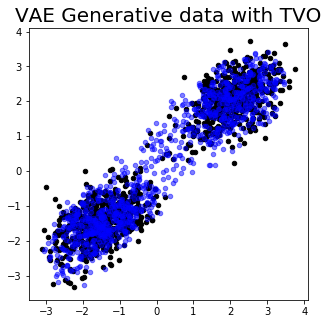

In [4]:
# Train with TVO, and visualize 
tvo_vae_instance = utils.train_TVO_LIN_VAE_batched(x_train,
                                                x_val,
                                                x_var=x_var,
                                                z_dim=2,
                                                width=50,
                                                hidden_layers=1,
                                                learning_rate=0.01,
                                                partition=torch.tensor([0.0,0.25,0.50,0.75,1.0]),
                                                S=10,
                                                n_epochs=5000,
                                                report_iter=50,
                                                batch_size=256,
                                                device=device)
utils.visualize_VAE(tvo_vae_instance,
                    x_train, 
                    "TVO",
                    x_var=x_var,
                    number_samples=1000, 
                    figsize=(5,5))

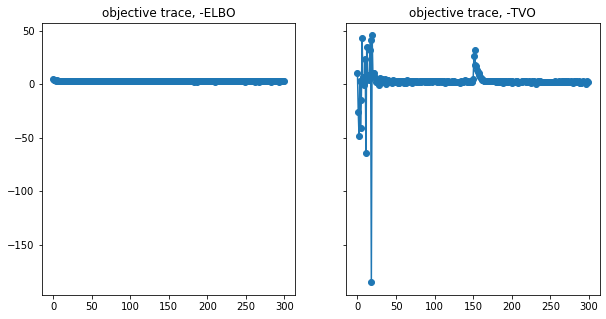

In [5]:
# Plot out the loss function trace
fig, ax=plt.subplots(1,2, figsize=(10,5), sharey=True)
ax[0].plot(elbo_vae_instance.objective_trace, 'o-')
ax[0].set_title('objective trace, -ELBO')
ax[1].plot(tvo_vae_instance.objective_trace, 'o-')
ax[1].set_title('objective trace, -TVO')
plt.show()

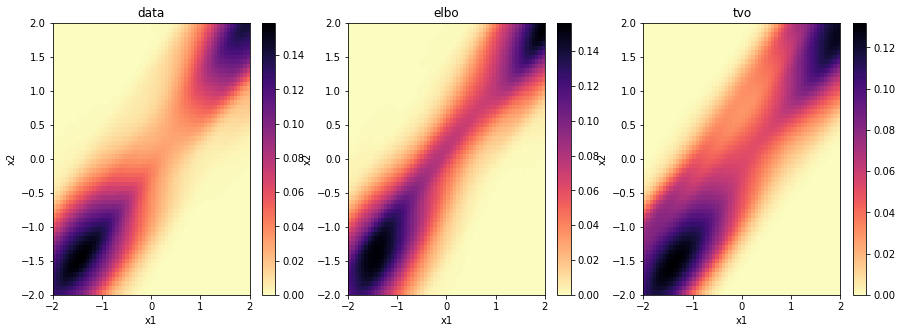

In [6]:
# Visualize PDF by a helper function
utils.compare_VAE(elbo_vae_instance, tvo_vae_instance, x_train,
                 number_samples=2000, x_var=x_var,
                 lim=2,
                 c_map='magma_r')

### 2. Unit test 2

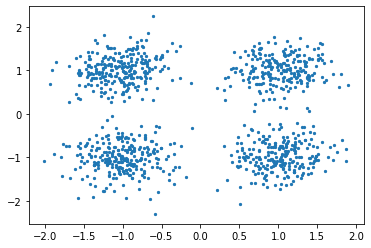

In [7]:
# Prepare x_train
c_means = [[-1.0, -1.0], [1.0, 1.0], [1.0, -1.0], [-1.0, 1.0]]
c_var = 0.05**2
x_var = 1e-2

indices = np.random.randint(4, size=1000)
train_samples = [np.random.multivariate_normal(c_means[i], c_var * np.eye(2) + 0.01 * np.ones((2, 2))) + np.random.multivariate_normal(np.zeros(2), x_var**0.5 * np.eye(2)) for i in indices]

indices = np.random.randint(4, size=500)
val_samples = [np.random.multivariate_normal(c_means[i], c_var * np.eye(2) + 0.01 * np.ones((2, 2))) + np.random.multivariate_normal(np.zeros(2), x_var**0.5 * np.eye(2)) for i in indices]

x_train = np.array(train_samples)
x_val = np.array(val_samples)
plt.scatter(x_train[:, 0], x_train[:, 1], s=5)
plt.show()

  0%|          | 18/5000 [00:07<57:24,  1.45it/s] 

At iteration 24 aggresive_flag is set to False


100%|██████████| 5000/5000 [01:02<00:00, 79.75it/s]


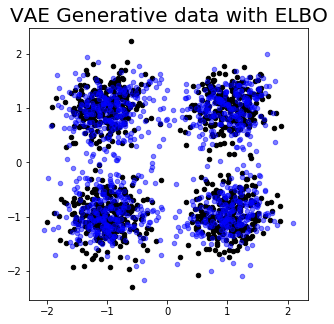

In [8]:
device = 'cpu'
elbo_vae_instance = utils.train_ELBO_LIN_VAE_batched(x_train,
                                                 x_val,
                                                 x_var=x_var,
                                                 z_dim=2,
                                                 width=50,
                                                 hidden_layers=1,
                                                 learning_rate=0.01,
                                                 S=10,
                                                 n_epochs=5000,
                                                 report_iter=50,
                                                 batch_size=256,
                                                 device=device)

utils.visualize_VAE(elbo_vae_instance, 
                    x_train, 
                    "ELBO", 
                    x_var=x_var,
                    number_samples=1000,
                    figsize=(5,5))

  0%|          | 13/5000 [00:08<1:24:42,  1.02s/it]

At iteration 18 aggresive_flag is set to False


100%|██████████| 5000/5000 [01:24<00:00, 59.29it/s]


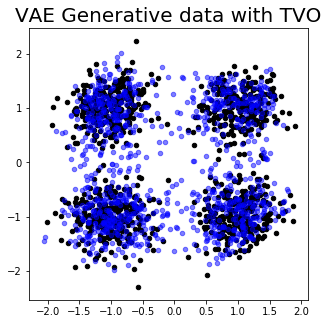

In [9]:
# Train with TVO, and visualize 
tvo_vae_instance = utils.train_TVO_LIN_VAE_batched(x_train,
                                                x_val,
                                                x_var=x_var,
                                                z_dim=2,
                                                width=50,
                                                hidden_layers=1,
                                                learning_rate=0.01,
                                                partition=torch.tensor([0.0,0.25,0.50,0.75,1.0]),
                                                S=10,
                                                n_epochs=5000,
                                                report_iter=50,
                                                batch_size=256,
                                                device=device)
utils.visualize_VAE(tvo_vae_instance,
                    x_train, 
                    "TVO",
                    x_var=x_var,
                    number_samples=1000, 
                    figsize=(5,5))

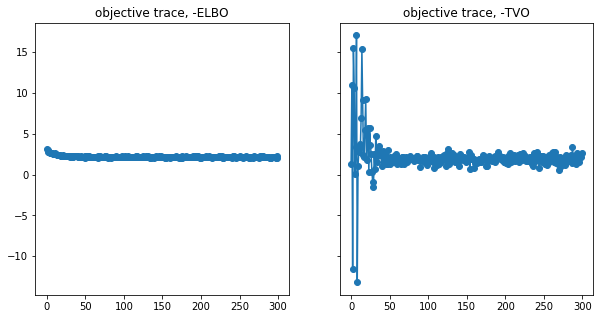

In [10]:
# Plot out the loss function trace
fig, ax=plt.subplots(1,2, figsize=(10,5), sharey=True)
ax[0].plot(elbo_vae_instance.objective_trace, 'o-')
ax[0].set_title('objective trace, -ELBO')
ax[1].plot(tvo_vae_instance.objective_trace, 'o-')
ax[1].set_title('objective trace, -TVO')
plt.show()

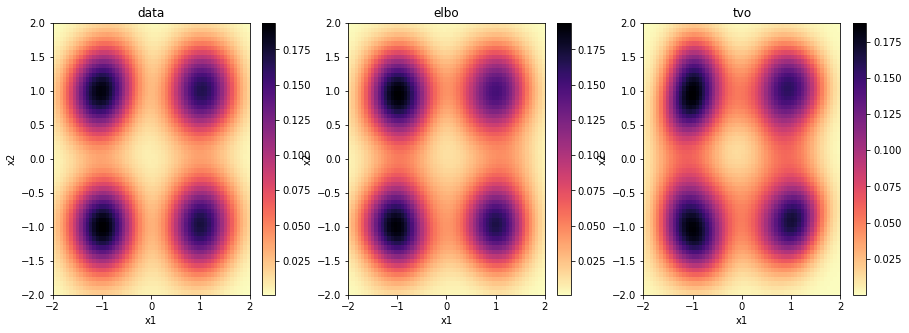

In [11]:
# Visualize PDF by a helper function
utils.compare_VAE(elbo_vae_instance, tvo_vae_instance, x_train,
                 number_samples=2000, x_var=x_var,
                 lim=2,
                 c_map='magma_r')